# Final Project
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__  
Throughout this course you’ve engaged with key principles required to develop scalable machine learning analyses for structured and unstructured data. Working in Hadoop Streaming and Spark you’ve learned to translate common machine learning algorithms into Map-Reduce style implementations. You’ve developed the ability to evaluate Machine Learning approaches both in terms of their predictive performance as well as their scalability. For the final project you will demonstrate these skills by solving a machine learning challenge on a new dataset. Your job is to perform Click Through Rate prediction on a large dataset of Criteo advertising data made public as part of a Kaggle competition a few years back. As you perform your analysis, keep in mind that we are not grading you on the final performance of your model or how ‘advanced’ the techniques you use but rather on your ability to explain and develop a scalable machine learning approach to answering a real question.

More about the dataset:
https://www.kaggle.com/c/criteo-display-ad-challenge

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [67]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "fproj_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [5]:
# create a data directory (RUN THIS CELL AS IS)
!mkdir data

In [6]:
# grab the tar.gz file from kaggle
!curl https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz -o data/dac.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 22 4364M   22  960M    0     0  2305k      0  0:32:19  0:07:06  0:25:13 2329k^C


In [5]:
!tar -xvzf data/dac.tar.gz

^C


In [7]:
# take a look at the to the training data set
!head data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16
0	2	0	44	1	102	8	2	2	4	1	1		4	68fd1e64	f0cf0024	6f67f7e5	41274cd7	25c83c98	fe6b92e5	922afcc0	0b153874	a73ee510	2b53e5fb	4f1b46f3	623049e6	d7020589	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		3a171ecb	43f13e8b	e8b83407	731c3655
0	2	0	1	14	767	89	4	2	245	1	3	3	45	287e684f	0a519c5c	02cf9876	c18be181	25c83c98	7e0ccccf	c78204a1	0b153874	a73ee510	3b08e48b	5f5e6091	8fe001f4	aa655a2f	07d13a8f	6dc710ed	36103458	8efede7f	3412118d			e587c466	ad3062eb	3a171ecb	3b183c5c		
0		893			4392		0	0	0		0			68fd1e64	2c16a946	a9a87e68	2e17d6f6	25c83c98	fe6b92e5	2e8a689b	0b153874	a73ee510	efea433b	e51ddf94	a30567ca	3516f6e6	07d13a8f	18231224	52b8680f	1e88c74f	74ef3502			6b3a5ca6		3a171ecb	9117a34a		
0	3	-1		0	2	0	3	0	0	1	1		0	8

In [8]:
# load the data into Spark RDD for convenience of use later (RUN THIS CELL AS IS)
projectRDD = sc.textFile('data/train.txt')

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Question Formulation 
Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful.

# Question 2: Algorithm Explanation
Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithym that you will perform.

# Question 3: EDA & Discussion of Challenges
Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform

In [9]:
average_CTR = projectRDD.map(lambda x: int(x.split('\t')[0])).mean()

In [10]:
average_CTR

0.25622338372976045

In [11]:
# helper function - RUN THIS CELL AS IS
def extractLabel(line):
    """Mapper to extract labels"""
    label = line[0]
    yield label

def extractTrain(line):
    """ Extracts train data"""
    train = line[1:]
    yield train

In [26]:
dataRDD = projectRDD.map(lambda x: x.split('\t')).cache()
labelrdd = dataRDD.flatMap(extractLabel).cache()

In [33]:
n_features = len(dataRDD.take(1)[0])

In [71]:
# Take sample of 1000
sample = np.array(dataRDD.takeSample(False,1000,seed=42))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

In [72]:
n_features

40

In [73]:
sample_df.to_pickle("./sample_df.pkl")


In [38]:
labelrdd.take(5)

['0', '0', '0', '0', '0']

In [92]:
integer_labels = ['I'+str(x) for x in range(1,14)]
integer_labels.insert(0,'output')
print(len(integer_labels))
categor_labels = ['C'+str(x) for x in range(1,27)]
FIELDS = integer_labels+categor_labels
print(len(FIELDS))

14
40


In [93]:
sample_df.columns=FIELDS
sample_df.head(10)

,output,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,1,NaN,18.0,3.0,2.0,4324.0,19.0,4.0,6.0,16.0,...,3486227d,47ecd034,NaN,NaN,93cc16aa,NaN,3a171ecb,afe9396a,NaN,NaN
1,0,NaN,2.0,3.0,NaN,361052.0,NaN,0.0,5.0,35.0,...,e5ba7672,e88ffc9d,55dd3565,a458ea53,74cb7e67,NaN,3a171ecb,3fdb382b,cb079c2d,49d68486
2,0,NaN,0.0,18.0,6.0,12345.0,630.0,6.0,17.0,548.0,...,e5ba7672,f6a2fc70,21ddcdc9,5840adea,99c09e97,NaN,32c7478e,335a6a1e,445bbe3b,3055b376
3,0,NaN,194.0,8.0,7.0,491.0,640.0,0.0,35.0,66.0,...,1e88c74f,bbf70d82,NaN,NaN,0429f84b,NaN,32c7478e,c0d61a5c,NaN,NaN
4,0,4.0,0.0,1.0,2.0,188.0,22.0,4.0,6.0,22.0,...,e5ba7672,5742e45c,NaN,NaN,21d7978f,NaN,32c7478e,812a6aff,NaN,NaN
5,1,1.0,1.0,NaN,10.0,2.0,8.0,1.0,13.0,8.0,...,d4bb7bd8,281769c2,NaN,NaN,dfcfc3fa,NaN,32c7478e,aee52b6f,NaN,NaN
6,0,NaN,0.0,NaN,1.0,0.0,NaN,0.0,1.0,23.0,...,1e88c74f,281769c2,NaN,NaN,d4703ebd,NaN,3a171ecb,aee52b6f,NaN,NaN
7,0,NaN,0.0,9.0,8.0,8259.0,17.0,4.0,34.0,41.0,...,e5ba7672,a10c0817,26e97973,5840adea,4b510454,NaN,32c7478e,2d3e3ac8,ea9a246c,b4a4615f
8,0,0.0,20.0,11.0,8.0,1729.0,115.0,3.0,9.0,27.0,...,e5ba7672,87fd936e,NaN,NaN,ead945fe,NaN,423fab69,5a456be6,NaN,NaN
9,1,20.0,0.0,16.0,1.0,171.0,52.0,73.0,38.0,91.0,...,e5ba7672,6fc84bfb,NaN,NaN,4f1aa25f,NaN,423fab69,ded4aac9,NaN,NaN


In [94]:
# Replace all empty strings with np.nan
sample_df = sample_df.replace(r'^\s*$', np.nan, regex=True)
sample_df.head(10)

,output,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,1,NaN,18.0,3.0,2.0,4324.0,19.0,4.0,6.0,16.0,...,3486227d,47ecd034,NaN,NaN,93cc16aa,NaN,3a171ecb,afe9396a,NaN,NaN
1,0,NaN,2.0,3.0,NaN,361052.0,NaN,0.0,5.0,35.0,...,e5ba7672,e88ffc9d,55dd3565,a458ea53,74cb7e67,NaN,3a171ecb,3fdb382b,cb079c2d,49d68486
2,0,NaN,0.0,18.0,6.0,12345.0,630.0,6.0,17.0,548.0,...,e5ba7672,f6a2fc70,21ddcdc9,5840adea,99c09e97,NaN,32c7478e,335a6a1e,445bbe3b,3055b376
3,0,NaN,194.0,8.0,7.0,491.0,640.0,0.0,35.0,66.0,...,1e88c74f,bbf70d82,NaN,NaN,0429f84b,NaN,32c7478e,c0d61a5c,NaN,NaN
4,0,4.0,0.0,1.0,2.0,188.0,22.0,4.0,6.0,22.0,...,e5ba7672,5742e45c,NaN,NaN,21d7978f,NaN,32c7478e,812a6aff,NaN,NaN
5,1,1.0,1.0,NaN,10.0,2.0,8.0,1.0,13.0,8.0,...,d4bb7bd8,281769c2,NaN,NaN,dfcfc3fa,NaN,32c7478e,aee52b6f,NaN,NaN
6,0,NaN,0.0,NaN,1.0,0.0,NaN,0.0,1.0,23.0,...,1e88c74f,281769c2,NaN,NaN,d4703ebd,NaN,3a171ecb,aee52b6f,NaN,NaN
7,0,NaN,0.0,9.0,8.0,8259.0,17.0,4.0,34.0,41.0,...,e5ba7672,a10c0817,26e97973,5840adea,4b510454,NaN,32c7478e,2d3e3ac8,ea9a246c,b4a4615f
8,0,0.0,20.0,11.0,8.0,1729.0,115.0,3.0,9.0,27.0,...,e5ba7672,87fd936e,NaN,NaN,ead945fe,NaN,423fab69,5a456be6,NaN,NaN
9,1,20.0,0.0,16.0,1.0,171.0,52.0,73.0,38.0,91.0,...,e5ba7672,6fc84bfb,NaN,NaN,4f1aa25f,NaN,423fab69,ded4aac9,NaN,NaN


In [95]:
sample_df[FIELDS[1:14]].isnull().sum()

I1     454
I2       0
I3     237
I4     234
I5      25
I6     237
I7      47
I8       0
I9      47
I10    454
I11     47
I12    761
I13    234
dtype: int64

In [101]:
sample_df[FIELDS[0:14]] = sample_df[FIELDS[0:14]].astype(float)

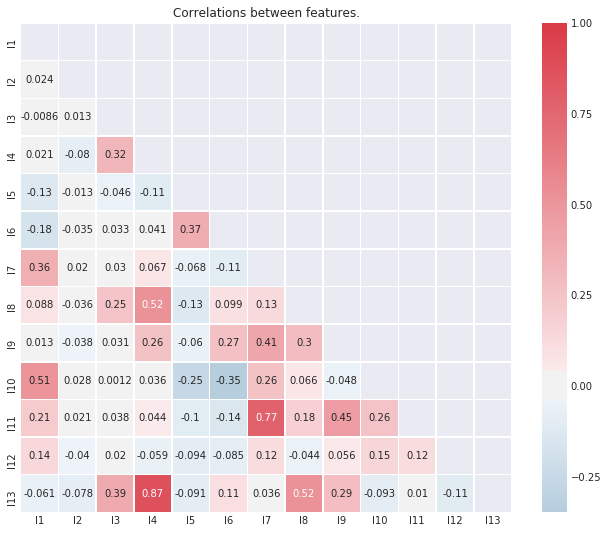

In [97]:
# Correlation between the dependent variables
corr = sample_df[FIELDS[1:14]].corr()
fig,ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

In [103]:
# Check correlation with target variable and other integer features
sample_df[FIELDS[0:14]].drop("output", axis=1).apply(lambda x: x.corr(sample_df[FIELDS[0:14]].output))

I1     0.123021
I2     0.069601
I3    -0.061049
I4    -0.111373
I5    -0.107616
I6    -0.182532
I7     0.166289
I8    -0.077193
I9     0.028167
I10    0.214147
I11    0.252108
I12    0.197804
I13   -0.164423
dtype: float64

In [113]:
# Convert categorical to one-hot. 
sample_df_onehot = pd.get_dummies(sample_df[FIELDS[14:]])
sample_df_onehot.head(5)

,C1_05db9164,C1_09ca0b81,C1_0a16e1d4,C1_0e78bd46,C1_127f4a6b,C1_1403b163,C1_1464facd,C1_17f69355,C1_241546e0,C1_24eda356,...,C26_fa8c3a8d,C26_fb7edec8,C26_fc5ab824,C26_fc7a0469,C26_fcd456fa,C26_fd0edb42,C26_fdd86175,C26_fdf9a32f,C26_ff267ebd,C26_ffe8822f
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Question 4: Algorithm Implementation 
Develop a 'homegrown' implementation of the algorithn, apply it to the training dataset and evaluate your results on the test set. 

# Question 5: Application of Course Concepts
Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts. 